In [ ]:
# Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.8.0


In [ ]:
# Load : Fashion MNIST Dataest
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

4431872/4422102 [==============================] - 0s 0us/step
The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


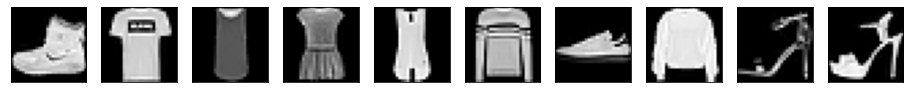

In [ ]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing 
# Normalization
x_train = x_train/255.  
x_test = x_test/255. 

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


In [ ]:
def channel_attention(x, name):
    filter = x.shape[3]
    gap = tf.keras.layers.AveragePooling2D(pool_size=(1,1))
    fc1 = tf.keras.layers.Dense(filter/4, activation = 'relu')
    fc2 = tf.keras.layers.Dense(filter, activation = 'sigmoid')
    tmp = gap(x)
    tmp = fc1(tmp)
    tmp = fc2(tmp)
    x = tf.multiply(x, tmp)

    return  x

def spatial_attention(x, name):
    conv1 = tf.keras.layers.Conv1D(filters = 1, kernel_size = 3, activation = 'sigmoid', padding = 'same')
    tmp = conv1(x)
    x = tf.multiply(x, tmp)

    return  x
 
def autoencoder_block(x, filter, name): 
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    return x

In [ ]:
#Attention Block in AutoEncoder network 

def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img



def autoencoder_channel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1_c')
    x = channel_attention(x, 'channel_attention')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1_c')(x)

    x = autoencoder_block(x, 32, 'encoder2_c')
    x = channel_attention(x, 'channel_attention')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2_c')(x)
    
    x = autoencoder_block(x, 64, 'encoder3_c')
    encoded_img = channel_attention(x, 'channel_attention')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1_c')
    x = channel_attention(x, 'channel_attention')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1_c')(x)

    x = autoencoder_block(x, 32, 'decoder2_c')
    x = channel_attention(x, 'channel_attention')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2_c')(x)

    x = autoencoder_block(x, 16, 'decoder3_c')
    x = channel_attention(x, 'channel_attention')
    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv_c')(x)
    return decoded_img    



def autoencoder_spatial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = spatial_attention(x, 'spatial_attention')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)

    x = autoencoder_block(x, 32, 'encoder2')
    x = spatial_attention(x,'spatial_attention')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)

    x = autoencoder_block(x, 64, 'encoder3')
    encoded_img = spatial_attention(x, 'spatial_attention')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = spatial_attention(x,'spatial_attention')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    
    x = autoencoder_block(x, 32, 'decoder2')
    x = spatial_attention(x,'spatial_attention')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    
    x = autoencoder_block(x, 16, 'decoder3')
    x = spatial_attention(x ,'spatial_attention')
    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img


def autoencoder_parallel_add(input):
    return autoencoder_channel(input) + autoencoder_spatial(input)

def autoencoder_parallel_mul(input):
    return autoencoder_channel(input) * autoencoder_spatial(input)

def autoencoder_serial_ca(input):
    x = autoencoder_channel(input)
    x = autoencoder_spatial(x)
    return x

def autoencoder_serial_sa(input):
    x = autoencoder_spatial(input)
    x = autoencoder_channel(x)
    return x



# Normal AutoEncoder Model 
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_data = autoencoder_channel(input_data)
output_spatial_data = autoencoder_spatial(input_data)
output_pa_add_data = autoencoder_parallel_add(input_data)
output_pa_mul_data = autoencoder_parallel_mul(input_data)
output_ser_ca_data = autoencoder_serial_ca(input_data)
output_ser_sa_data = autoencoder_serial_sa(input_data)


model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel  = tf.keras.Model(inputs=input_data, outputs=output_channel_data)
model_spatial = tf.keras.Model(inputs=input_data, outputs=output_spatial_data)
model_pa_add = tf.keras.Model(inputs=input_data, outputs=output_pa_add_data)
model_pa_mul = tf.keras.Model(inputs=input_data, outputs=output_pa_mul_data)
model_ser_ca = tf.keras.Model(inputs=input_data, outputs=output_ser_ca_data)
model_ser_sa = tf.keras.Model(inputs=input_data, outputs=output_ser_sa_data)


model.summary()
model_channel.summary()
model_spatial.summary()
model_pa_add.summary()
model_pa_mul.summary()
model_ser_ca.summary()
model_ser_sa.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder1_conv (Conv2D)      (None, 28, 28, 16)        160       
                                                                 
 encoder1_bn (BatchNormaliza  (None, 28, 28, 16)       64        
 tion)                                                           
                                                                 
 encoder1_relu (ReLU)        (None, 28, 28, 16)        0         
                                                                 
 encoder_pool1 (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 encoder2_conv (Conv2D)      (None, 14, 14, 32)        4640  

In [ ]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

model_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_spatial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_pa_add.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_pa_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_ser_ca.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_ser_sa.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model')


history = model.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_channel = model_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_spatial = model_spatial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_pa_add = model_pa_add.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_pa_mul = model_pa_mul.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_ser_ca = model_ser_ca.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_ser_sa = model_ser_sa.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model
Epoch 1/5
3750/3750 [==============================] - 50s 11ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/5
3750/3750 [==============================] - 40s 11ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 3/5
3750/3750 [==============================] - 40s 11ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/5
3750/3750 [==============================] - 41s 11ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 5/5
3750/3750 [==============================] - 41s 11ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 1/5
3750/3750 [==============================] - 72s 19ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/5
3750/3750 [==============================] - 63s 17ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 3/5
3750/3750 [===================

In [ ]:
# Model Predict
recons = model.predict(x_test)
recons_channel = model_channel.predict(x_test)
recons_spatial = model_spatial.predict(x_test)
recons_pa_add = model_pa_add.predict(x_test)
recons_pa_mul = model_pa_mul.predict(x_test)
recons_ser_ca = model_ser_ca.predict(x_test)
recons_ser_sa = model_ser_sa.predict(x_test)


In [ ]:
recons = recons.reshape(-1, 28, 28)
recons_channel = recons_channel.reshape(-1, 28, 28)
recons_spatial = recons_spatial.reshape(-1, 28, 28)
recons_pa_add = recons_pa_add.reshape(-1, 28, 28)
recons_pa_mul = recons_pa_mul.reshape(-1, 28, 28)
recons_ser_ca = recons_ser_ca.reshape(-1, 28, 28)
recons_ser_sa = recons_ser_sa.reshape(-1, 28, 28)

test_imgs = (x_test * 255).reshape(-1, 28, 28)

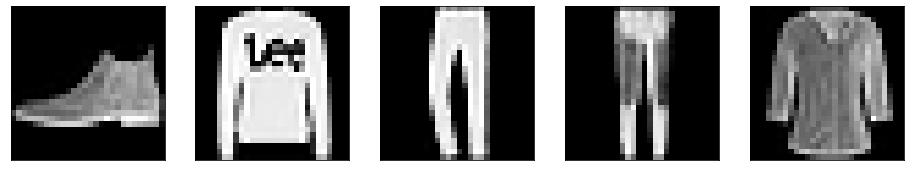

In [ ]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

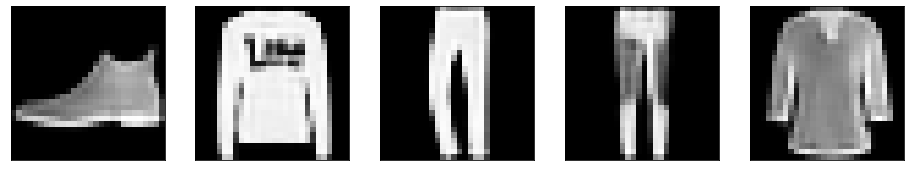

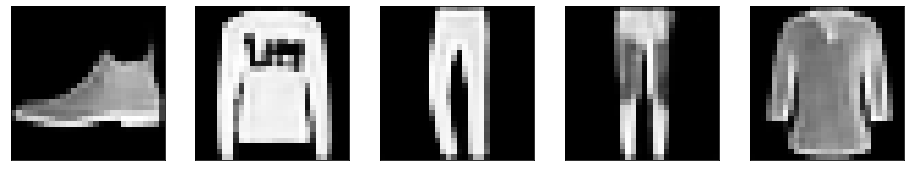

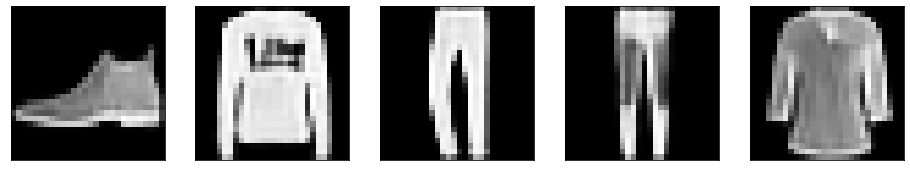

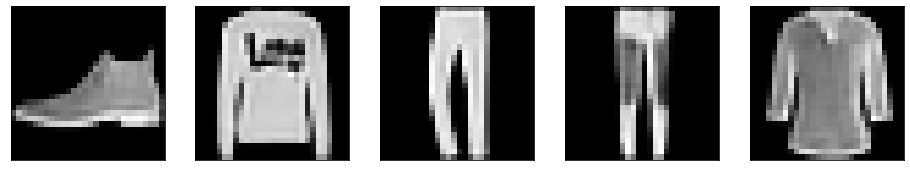

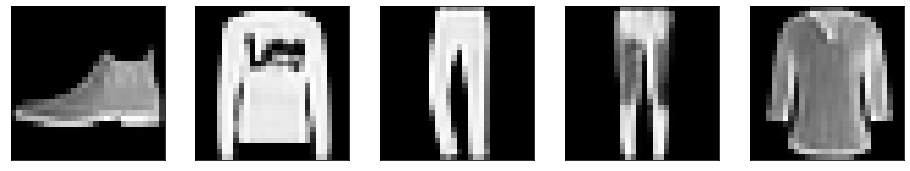

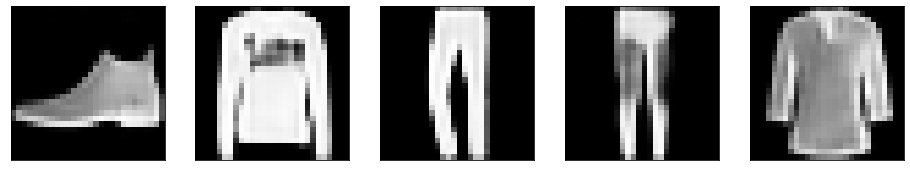

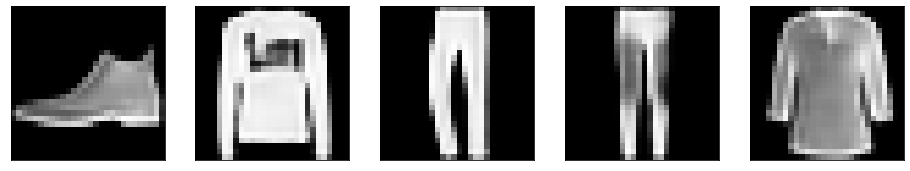

In [ ]:
# Predictions Visualization

fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

#channel
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

#spatial
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

#parallel_add
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_pa_add[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

#parallel_mul
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_pa_mul[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

#serial_ca
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_ser_ca[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

#serial_sa
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_ser_sa[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

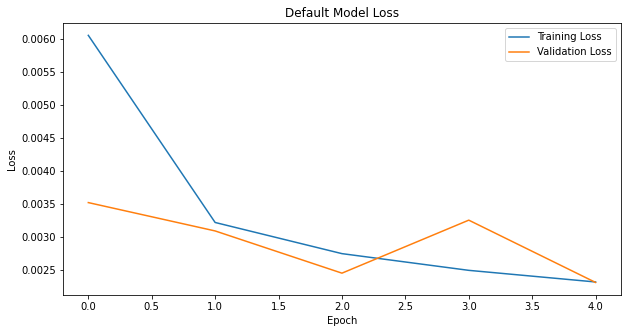

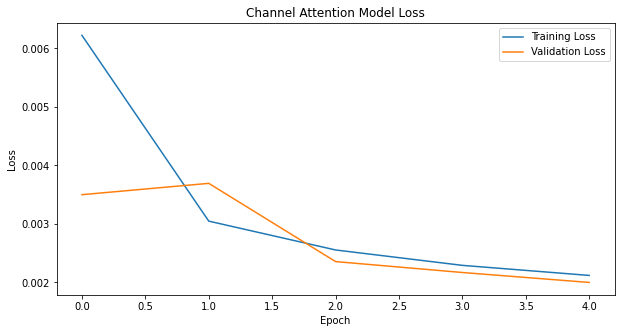

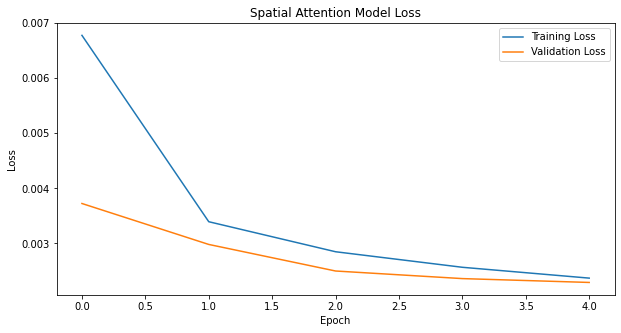

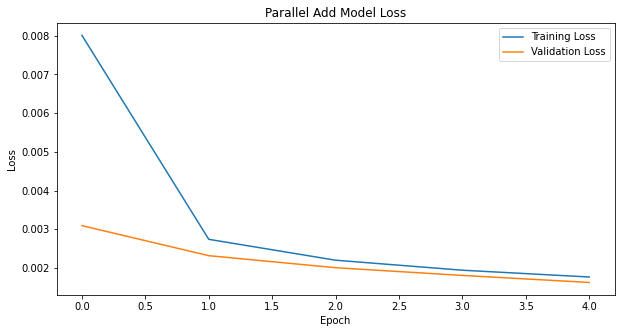

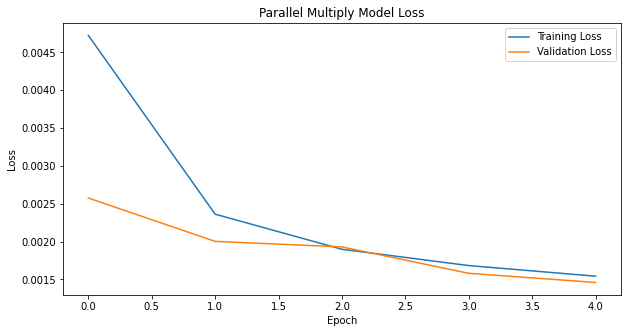

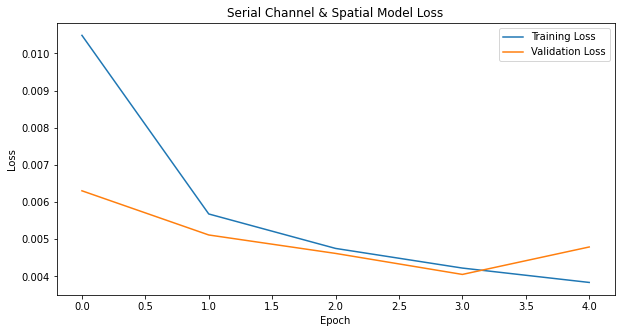

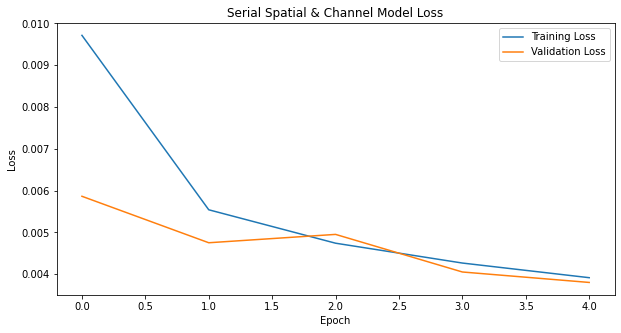

In [ ]:
#autoencoder_def
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Default Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

#channel
plt.figure(figsize=(10, 5))

plt.plot(history_channel.history['loss'])
plt.plot(history_channel.history['val_loss'])
plt.title('Channel Attention Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

#spatial
plt.figure(figsize=(10, 5))

plt.plot(history_spatial.history['loss'])
plt.plot(history_spatial.history['val_loss'])
plt.title('Spatial Attention Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

#parallel_add
plt.figure(figsize=(10, 5))

plt.plot(history_pa_add.history['loss'])
plt.plot(history_pa_add.history['val_loss'])
plt.title('Parallel Add Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

#parallel_mul
plt.figure(figsize=(10, 5))

plt.plot(history_pa_mul.history['loss'])
plt.plot(history_pa_mul.history['val_loss'])
plt.title('Parallel Multiply Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

#serial_ca
plt.figure(figsize=(10, 5))

plt.plot(history_ser_ca.history['loss'])
plt.plot(history_ser_ca.history['val_loss'])
plt.title('Serial Channel & Spatial Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

#serial_sa
plt.figure(figsize=(10, 5))

plt.plot(history_ser_sa.history['loss'])
plt.plot(history_ser_sa.history['val_loss'])
plt.title('Serial Spatial & Channel Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()